# Installing and Importing the Required Libraries

In [90]:
#!pip install networkx==2.3

In [91]:
#!pip install mlxtend==0.14.0

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline
from mlxtend.frequent_patterns import apriori,association_rules
from collections import Counter
from IPython.display import Image

# Importing the data as df

In [93]:
#importing the data
df = pd.read_csv('data.csv',encoding= 'unicode_escape')
df.shape

(541909, 8)

In [94]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [95]:
df.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

# Cleaning the data

In [96]:
df1 = df.dropna()

In [97]:
df1.describe()

# Here we can see quantity has some negative values which is a part of incorrect data so we will drop such entries

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [98]:
#selecting data where quantity > 0
df1 = df1[df1.Quantity > 0]

In [99]:
df1.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


# Insights from the dataset

## Customers Insights

This segment will answer the questions like :
1. Who all are my loyal customers?
2. Which customers have ordered most frequently?
3. Which customers contribute the most to my revenue?

In [100]:
# Creating a new feature 'Amount' which is the product of Quantity and its Unit Price

df1['Amount'] = df1['Quantity'] * df1['UnitPrice']

In [101]:
# Using groupby function to highlight the Customers with most no. of orders (invoices)

orders = df1.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count()
orders.head()

,CustomerID,Country,InvoiceNo
0,12346.0,United Kingdom,1
1,12347.0,Iceland,182
2,12348.0,Finland,31
3,12349.0,Italy,73
4,12350.0,Norway,17


In [102]:
print('The TOP 5 loyal customers with most number of orders...')
orders.sort_values(by='InvoiceNo', ascending=False).head()

The TOP 5 loyal customers with most number of orders...


,CustomerID,Country,InvoiceNo
4019,17841.0,United Kingdom,7847
1888,14911.0,EIRE,5677
1298,14096.0,United Kingdom,5111
334,12748.0,United Kingdom,4596
1670,14606.0,United Kingdom,2700


### Number of Orders by Different Customers

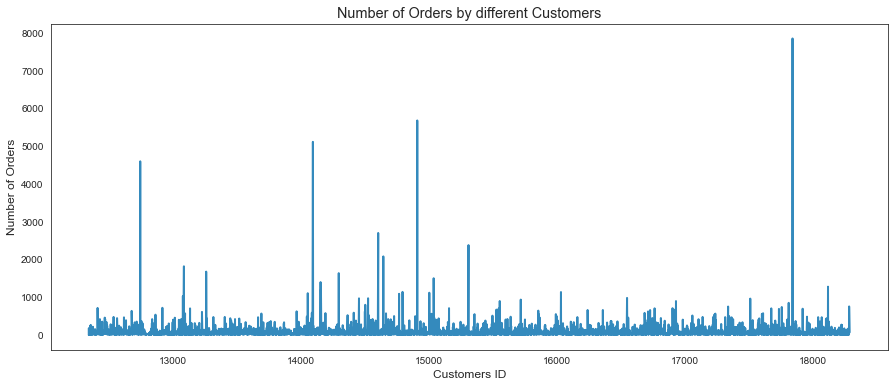

In [103]:
# Creating a subplot of size 15x6
plt.subplots(figsize=(15,6))

# Using the style bmh for better visualization
plt.style.use('bmh')

# X axis will denote the customer ID, Y axis will denote the number of orders
plt.plot(orders.CustomerID, orders.InvoiceNo)

# Labelling the X axis
plt.xlabel('Customers ID')

# Labelling the Y axis
plt.ylabel('Number of Orders')

# Giving a suitable title to the plot
plt.title('Number of Orders by different Customers')

plt.show()

In [104]:
# Using groupby function to highlight the Customers with highest spent amount (invoices)

money_spent = df1.groupby(by=['CustomerID','Country'], as_index=False)['Amount'].sum()

In [105]:
print('The TOP 5 profitable customers with highest money spent...')
money_spent.sort_values(by='Amount', ascending=False).head()

The TOP 5 profitable customers with highest money spent...


,CustomerID,Country,Amount
1698,14646.0,Netherlands,280206.02
4210,18102.0,United Kingdom,259657.30
3737,17450.0,United Kingdom,194550.79
3017,16446.0,United Kingdom,168472.50
1888,14911.0,EIRE,143825.06


### Money Spent by Different Customers

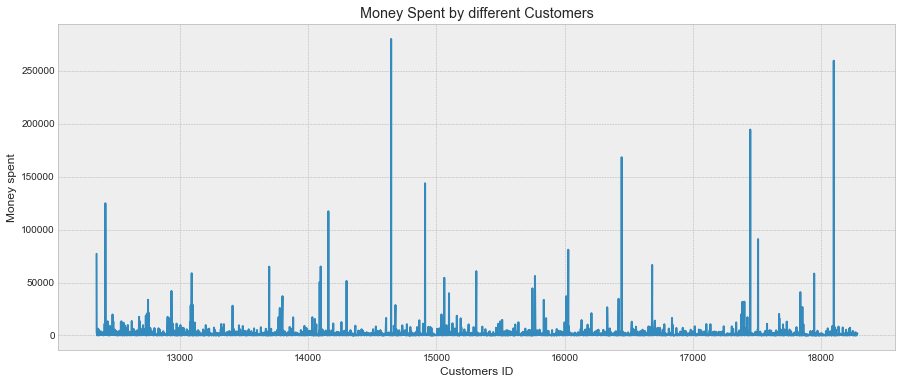

In [106]:
# Creating a subplot of size 15*6
plt.subplots(figsize=(15,6))

# X axis will denote the customer ID, Y axis will denote the amount spent
plt.plot(money_spent.CustomerID, money_spent.Amount)

# Using bmh style for better visualization
plt.style.use('bmh')

# Labelling the X-axis
plt.xlabel('Customers ID')

# Labelling the Y-axis
plt.ylabel('Money spent')

# Giving a suitable title to the plot
plt.title('Money Spent by different Customers')

plt.show()

## Patterns based on DateTime

This segment will answer the questions like:
1. In which month, the number of orders placed is the highest?
2. On which Day of a week, the number of orders placed is the highest?
3. At what time of the day, the store is the busiest?

In [107]:
import datetime

In [108]:
# Convert InvoiceDate from object to datetime
df1['InvoiceDate'] = pd.to_datetime(df1.InvoiceDate, format='%m/%d/%Y %H:%M')

# Creating a new feature called year_month, such that December 2010 will be denoted as 201012
df1.insert(loc=2, column='year_month', value=df1['InvoiceDate'].map(lambda x: 100*x.year + x.month))

# Creating a new feature for Month
df1.insert(loc=3, column='month', value=df1.InvoiceDate.dt.month)

# Creating a new feature for Day
# +1 to make Monday=1.....until Sunday=7
df1.insert(loc=4, column='day', value=(df1.InvoiceDate.dt.dayofweek)+1)

# Creating a new feature for Hour
df1.insert(loc=5, column='hour', value=df1.InvoiceDate.dt.hour)

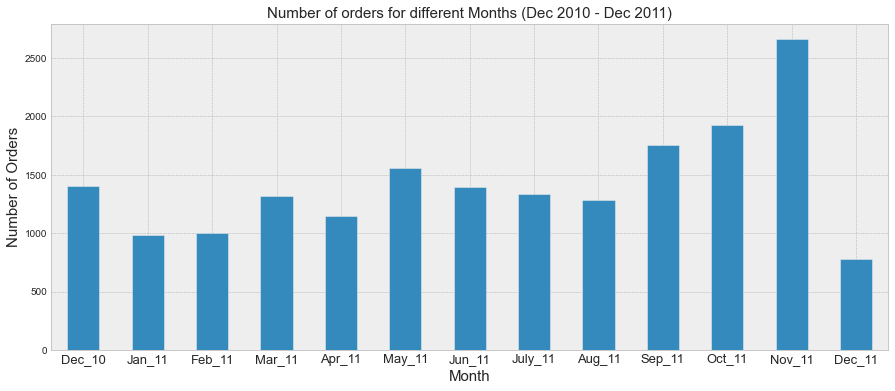

In [109]:
# Using bmh style for better visualization
plt.style.use('bmh')

# Using groupby to extract No. of Invoices year-monthwise
ax = df1.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))

# Labelling the X axis
ax.set_xlabel('Month',fontsize=15)

# Labelling the Y-axis
ax.set_ylabel('Number of Orders',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Number of orders for different Months (Dec 2010 - Dec 2011)',fontsize=15)

# Providing with X tick labels
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)

plt.show()

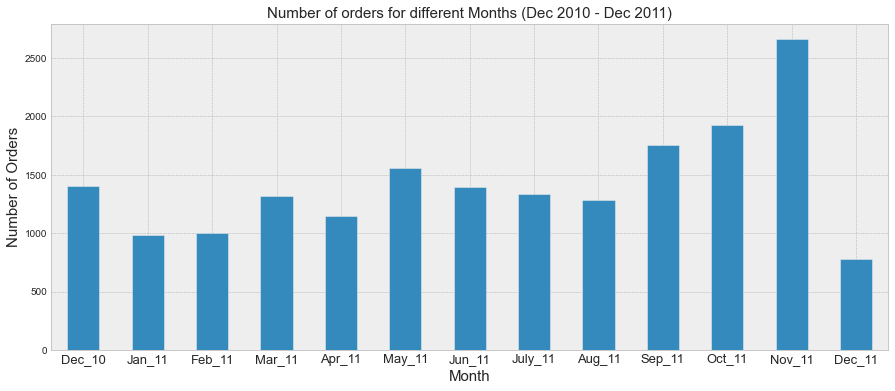

In [110]:
# Using bmh style for better visualization
plt.style.use('bmh')

# Using groupby to extract No. of Invoices year-monthwise
ax = df1.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))

# Labelling the X axis
ax.set_xlabel('Month',fontsize=15)

# Labelling the Y-axis
ax.set_ylabel('Number of Orders',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Number of orders for different Months (Dec 2010 - Dec 2011)',fontsize=15)

# Providing with X tick labels
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)

plt.show()

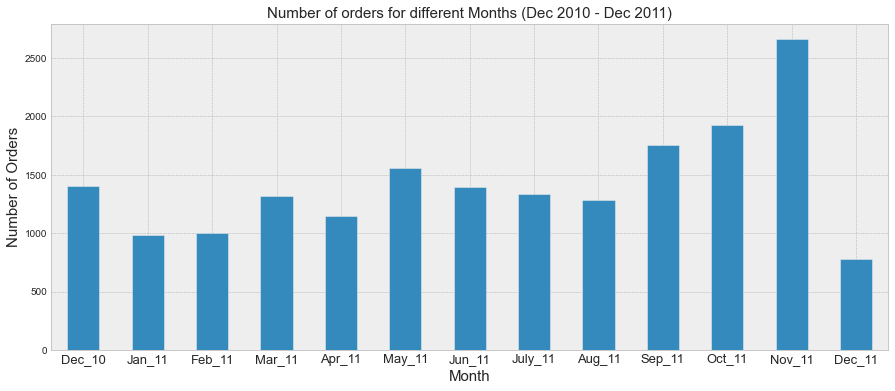

In [111]:
# Using bmh style for better visualization
plt.style.use('bmh')

# Using groupby to extract No. of Invoices year-monthwise
ax = df1.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))

# Labelling the X axis
ax.set_xlabel('Month',fontsize=15)

# Labelling the Y-axis
ax.set_ylabel('Number of Orders',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Number of orders for different Months (Dec 2010 - Dec 2011)',fontsize=15)

# Providing with X tick labels
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)

plt.show()

### How many orders are placed per Day?

In [112]:
# Day = 6 is Saturday and there are no orders placed on Saturdays
df1[df1['day']==6]

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount


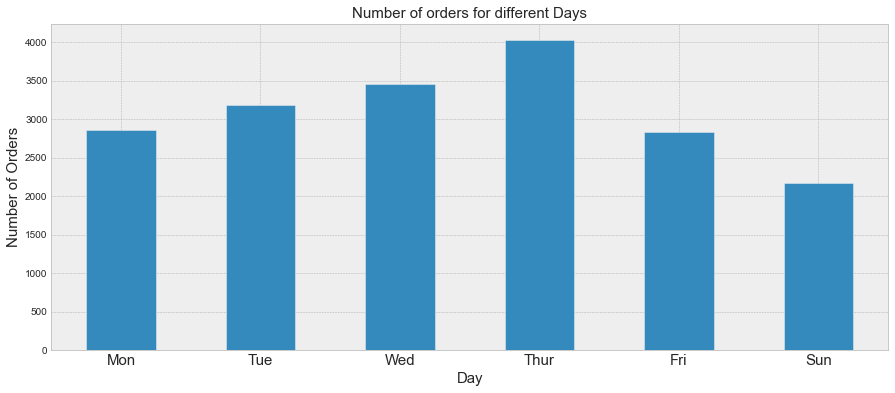

In [113]:
# Using groupby to count no. of Invoices daywise
ax = df1.groupby('InvoiceNo')['day'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))

# Labelling X axis
ax.set_xlabel('Day',fontsize=15)

# Labelling Y axis
ax.set_ylabel('Number of Orders',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Number of orders for different Days',fontsize=15)

# Providing with X tick labels
# Since there are no orders placed on Saturdays, we are excluding Sat from xticklabels
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)

plt.show()

### How many orders are placed per Hour?

In [114]:
# Using groupby to count the no. of Invoices hourwise
"""ax = df1.groupby('InvoiceNo')['hour'].unique().value_counts().iloc[:-1].sort_index().plot(kind='bar',figsize=(15,6))

# Labelling X axis
ax.set_xlabel('Hour',fontsize=15)

# Labelling Y axis
ax.set_ylabel('Number of Orders',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Number of orders for different Hours',fontsize=15)

# Providing with X tick lables ( all orders are placed between 6 and 20 hour )
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()"""
print()

### Free Items and Sales

This segment will display how FREE items impact the No. of Orders. This answers how will the discounts and offers impact my sale?

In [115]:
df1.UnitPrice.describe()
# With minimum Unit Price = 0 there can be either some incorrect entry or free items

count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

C:\Users\aryan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


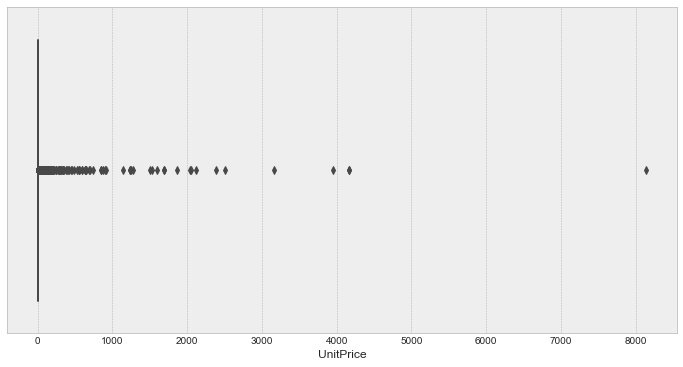

In [116]:
# checking the distribution of unit price
plt.subplots(figsize=(12,6))

# Using darkgrid style for better visualization
sns.set_style('darkgrid')

# Applying boxplot visualization on Unit Price
sns.boxplot(df1.UnitPrice)

plt.show()

Items with UnitPrice = 0 are not outliers, these are the free items.

In [117]:
# Creating a new df of free items
free_items = df1[df1['UnitPrice'] == 0]
free_items.head()

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
9302,537197,22841,201012,12,7,14,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,0.0
33576,539263,22580,201012,12,4,14,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,0.0
40089,539722,22423,201012,12,2,13,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,0.0
47068,540372,22090,201101,1,4,16,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0.0
47070,540372,22553,201101,1,4,16,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0.0


In [118]:
# Counting how many free items were given out year-month wise
free_items.year_month.value_counts().sort_index()

201012     3
201101     3
201102     1
201103     2
201104     2
201105     2
201107     2
201108     6
201109     2
201110     3
201111    14
Name: year_month, dtype: int64

There is atleast one free item every month except June 2011

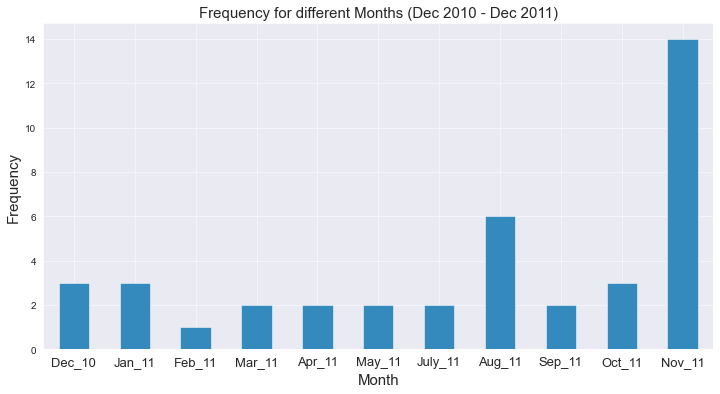

In [119]:
# Counting how many free items were given out year-month wise
ax = free_items.year_month.value_counts().sort_index().plot(kind='bar',figsize=(12,6))

# Labelling X-axis
ax.set_xlabel('Month',fontsize=15)

# Labelling Y-axis
ax.set_ylabel('Frequency',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Frequency for different Months (Dec 2010 - Dec 2011)',fontsize=15)

# Providing X tick labels
# Since there are 0 free items in June 2011, we are excluding it
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11'), rotation='horizontal', fontsize=13)
plt.show()

The most no. of free items were given out in November 2011. Also, the most no. of orders were placed in November 2011 as seen below :

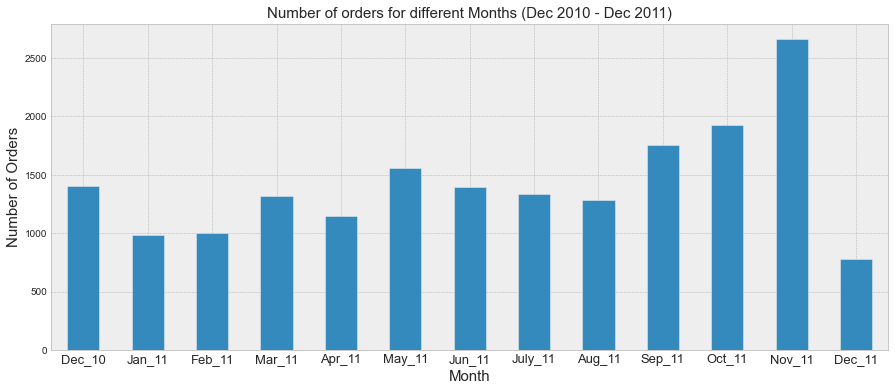

In [120]:
plt.style.use('bmh')

# Using groupby to count unique no. of Invoices year-month wise
ax = df1.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))

# Labelling X axis
ax.set_xlabel('Month',fontsize=15)

# Labelling Y axis
ax.set_ylabel('Number of Orders',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Number of orders for different Months (Dec 2010 - Dec 2011)',fontsize=15)

# Providing with X tick labels
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)

plt.show()

Also, compared to May, sales declined which means there was a slight effect of NO FREE ITEMS on the number of orders.

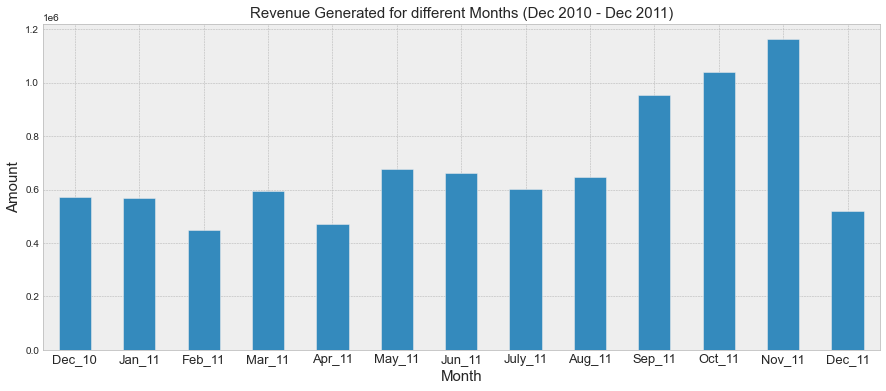

In [121]:
plt.style.use('bmh')

# Using groupby to sum the amount spent year-month wise
ax = df1.groupby('year_month')['Amount'].sum().sort_index().plot(kind='bar',figsize=(15,6))

# Labelling X axis
ax.set_xlabel('Month',fontsize=15)

# Labelling Y axis
ax.set_ylabel('Amount',fontsize=15)

# Giving suitable title to the plot
ax.set_title('Revenue Generated for different Months (Dec 2010 - Dec 2011)',fontsize=15)

# Providing with X tick labels
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)

plt.show()

## Items Insights

This segment will answer the questions like :
1. Which item is bought by most no. of customers?
2. Which is the most sold item based on sum of sales?
3. Which is the most sold item based on the count of orders?
4. Which items are the first choice items for most no. of invoices?

### Most sold item based on Quantity

In [122]:
# Creating a new pivot table which sums the Quantity ordered for each item

most_sold_items = df1.pivot_table(index=['StockCode','Description'], values='Quantity', aggfunc='sum').sort_values(by='Quantity', ascending=False)

Text(0, 0.5, 'Item')

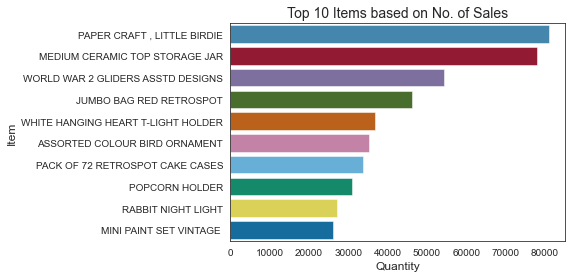

In [123]:
most_sold_items.reset_index(inplace=True)
sns.set_style('white')

# Creating a bar plot of Description ( or the item ) on the Y axis and the sum of Quantity on the X axis
# We are plotting only the 10 most ordered items
sns.barplot(y='Description', x='Quantity', data=most_sold_items.head(10))

# Giving suitable title to the plot
plt.title('Top 10 Items based on No. of Sales', fontsize=14)

plt.ylabel('Item')

### Items bought by most no. of Customers

In [124]:
# choosing WHITE HANGING HEART T-LIGHT HOLDER as a sample

df_white = df1[df1['Description']=='WHITE HANGING HEART T-LIGHT HOLDER']

In [125]:
# This denotes that WHITE HANGING HEART T-LIGHT HOLDER has been ordered 2028 times

df_white.shape

(2028, 13)

In [126]:
# This denotes that WHITE HANGING HEART T-LIGHT HOLDER has been ordered by 856 customers

len(df_white.CustomerID.unique())

856

In [127]:
# Creating a pivot table that displays the sum of unique Customers who bought particular item

bought_by_most_customers = df1.pivot_table(index=['StockCode','Description'], values='CustomerID', aggfunc=lambda x: len(x.unique())).sort_values(by='CustomerID', ascending=False)

In [128]:
bought_by_most_customers

# Since the count for WHITE HANGING HEART T-LIGHT HOLDER matches above length 856, the pivot table looks correct for all items

,,CustomerID
StockCode,Description,
22423,REGENCY CAKESTAND 3 TIER,881
85123A,WHITE HANGING HEART T-LIGHT HOLDER,856
47566,PARTY BUNTING,708
84879,ASSORTED COLOUR BIRD ORNAMENT,678
22720,SET OF 3 CAKE TINS PANTRY DESIGN,640
...,...,...
21897,POTTING SHED CANDLE CITRONELLA,1
84795C,OCEAN STRIPE HAMMOCK,1
90125E,AMBER BERTIE GLASS BEAD BAG CHARM,1


Text(0, 0.5, 'Item')

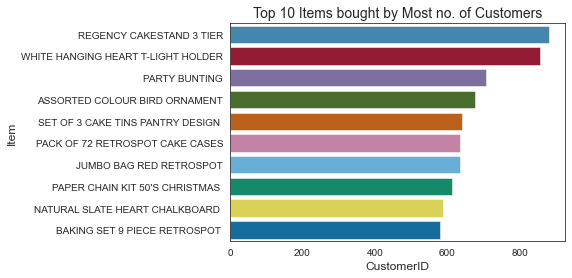

In [129]:
bought_by_most_customers.reset_index(inplace=True)
sns.set_style('white')

# Creating a bar plot of Description ( or the item ) on the Y axis and the sum of unique Customers on the X axis
# We are plotting only the 10 most bought items
sns.barplot(y='Description', x='CustomerID', data=bought_by_most_customers.head(10))

# Giving suitable title to the plot
plt.title('Top 10 Items bought by Most no. of Customers', fontsize=14)

plt.ylabel('Item')

### Most Frequently Ordered Items

### Top 10 First Choices 

In [130]:
# Storing all the invoice numbers into a list y
y = df1['InvoiceNo']
y = y.to_list()

In [131]:
# Length of y
len(y)

397924

In [132]:
# Using set function to find unique invoice numbers only and storing them in invoices list
invoices = list(set(y))

# Lenght of invoices ( or count of unique invoice numbers )
len(invoices)

18536

In [133]:
# Creating empty list first_choices
first_choices = []

# looping into list of unique invoice numbers
for i in invoices:
    
    # the first item (index = 0) of every invoice is the first purchase
    # extracting the item name for the first purchase
    first_purchase = df1[df1['InvoiceNo']==i]['items'].reset_index(drop=True)[0]
    
    # Appending the first purchase name into first choices list
    first_choices.append(first_purchase)

KeyError: 'items'

In [ ]:
first_choices[:5]

In [ ]:
# Length of first_choices mathches the lenght of invoices
len(first_choices)

In [ ]:
# Using counter to count repeating first choices
count = Counter(first_choices)

In [ ]:
# Storing the counter into a datafrane
df_first_choices = pd.DataFrame.from_dict(count, orient='index').reset_index()

# Rename columns as item and count
df_first_choices.rename(columns={'index':'item', 0:'count'},inplace=True)

# Sorting the df based on count
df_first_choices.sort_values(by='count',ascending=False)

In [ ]:
plt.subplots(figsize=(20,10))
sns.set_style('white')

# Creating a bar plot that displays Item name on the Y axis and Count on the X axis
sns.barplot(y='item', x='count', data=df_first_choices.sort_values(by='count',ascending=False).head(10))

# Giving suitable title to the plot
plt.title('Top 10 First Choices', fontsize=14)

plt.ylabel('Item')

# Frequently Bought Together

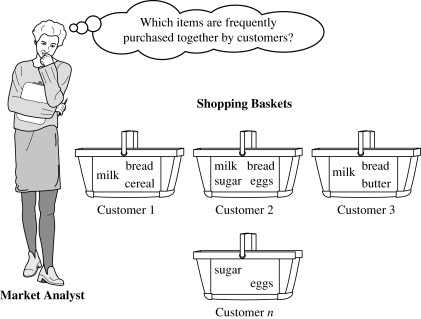

Market basket analysis is a data mining technique used by retailers to increase sales by better understanding customer purchasing patterns. It involves analyzing large data sets, such as purchase history, to reveal product groupings, as well as products that are likely to be purchased together.

This segment will answer the questions like:
1. Which items are frequently bought together?
2. If a user buys an item X, which item is he/she likely to buy next?

In [ ]:
# Using groupby function to create a basket df, which specifies if an item is present in a particular invoiceno
# for all items and all invoices
# this will denote the quantity present in the particular invoiceno which needs to be fixed

basket = (df1.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))

In [ ]:
basket.head(10)

In [ ]:
#We are getting the quantity ordered (example : 48,24,126) while we just want to know if that particular item is purchased or not
#thus we are encoding units as 1(if purchased) or 0(not purchased)

def encode_units(x):
    if x < 1:
        return 0
    if x >= 1:
        return 1


basket = basket.applymap(encode_units)

In [ ]:
# this looks good as everything is ecnoded into 0 and 1
basket.head(10)

### Apriori Algorithm Concepts
What is Support,Confidence and Lift?

In [ ]:
#Image("Support_Explanation.jpg")

 Example :
 If out of 100 users, 10 purchase Milk then support for Milk will be 10/100 = 10%
 The formula for calculation is as given below :

In [ ]:
#Image("Support_Formula.jpg")

In [ ]:
#Image("Confidence_Explanation.jpg")

Suppose we are looking to build relation between Milk and Bread.
So if out of 40 milk buyers, 7 buy bread along with it then confidence = 7/40 = 17.5%

The formula to calculate confidence is as given below :

In [ ]:
#Image("Confidence_Formula.jpg")

In [ ]:
#Image("Lift.jpg")

lift = confidence/support
So here lift = 17.5/10 = 1.75

### Association Rules

Association rule mining finds interesting associations and relationships among large sets of data items. This rule shows how frequently a itemset occurs in a transaction. Based on those rules created from the Dataset, we perform Market Basket Analysis.

In [ ]:
#Image("Rules.png",width=800)

From the above image,
Out of 5 transactions where mobile was purchased, 3 of them has mobile screen guard along with it.
Thus it should be recommended

### Implementation using mlxtend

In [ ]:
# trying out on a sample item
wooden_star_df = basket.loc[basket['WOODEN STAR CHRISTMAS SCANDINAVIAN']==1]

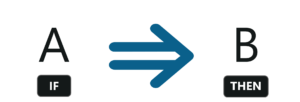

In [ ]:
# Using apriori algorithm, creating association rules for the sample item

# Applying apriori algorithm for wooden_star_df
frequent_itemsets = apriori(wooden_star_df, min_support=0.15, use_colnames=True)

# Storing the association rules into rules
wooden_star_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sorting the rules on lift and support
wooden_star_rules.sort_values(['lift','support'],ascending=False).reset_index(drop=True)

mlxtend Docs: http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/#association-rules-generation-from-frequent-itemsets

## Creating the function 

In [ ]:
# Creating a new function in which we pass an item name and it returns the items which are frequently bought together
# In other words, it returns the items which are likely to be bought by user because he bought the item passed into function

def frequently_bought_together(item):
    
    # df of item passed
    item_df = basket.loc[basket[item]==1]
    
    # Applying apriori algorithm on item df
    frequent_itemsets = apriori(item_df, min_support=0.15, use_colnames=True)
    
    # Storing association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    
    # Sorting on lift and support
    rules.sort_values(['lift','support'],ascending=False).reset_index(drop=True)
    
    print('Items frequently bought together with {0}'.format(item))
    
    # Returning top 6 items with highest lift and support
    return rules['consequents'].unique()[:6]

In [ ]:
# Example 1
frequently_bought_together('WOODEN STAR CHRISTMAS SCANDINAVIAN')

In [ ]:
# Example 2
frequently_bought_together('WHITE METAL LANTERN')

In [ ]:
# Example 3
frequently_bought_together('JAM MAKING SET WITH JARS')

### Validation

In [ ]:
# JAM MAKING SET PRINTED is a part of invoice 536390, so we will print all items from invoice 536390 and cross-check 
df1[df1['InvoiceNo']=='536390']

# There are a couple of common items between the recommendations from frequently_bought_together and the invoice below
# Thus we can say the recommender is performing well

## Visualization of Association Rules

In [ ]:
# For a sample, we will try out visualization techniques on Wooden Star df which we used earlier

support=wooden_star_rules.support.values
confidence=wooden_star_rules.confidence.values

In [ ]:
import networkx as nx

In [ ]:
import random
import matplotlib.pyplot as plt
 
for i in range (len(support)):
    support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5) 
    confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)

# Creating a scatter plot of support v confidence    
plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

In [ ]:
def wooden_star_graph(wooden_star_rules, no_of_rules):
  G1 = nx.DiGraph()
   
  color_map=[]
  N = 50
  colors = np.random.rand(N)    
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
   
   
  for i in range (no_of_rules):      
    
    # adding as many nodes as number of rules requested by user
    G1.add_nodes_from(["R"+str(i)])
    
    # adding antecedents to the nodes 
    for a in wooden_star_rules.iloc[i]['antecedents']:
                
        G1.add_nodes_from([a])
        
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
    
    # adding consequents to the nodes
    for c in wooden_star_rules.iloc[i]['consequents']:
             
            G1.add_nodes_from([c])
            
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
  for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')       
 
 
   
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]
 
  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
  for p in pos:  # raise text positions
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)
  plt.show()

In [ ]:
wooden_star_graph(wooden_star_rules,5)

In [ ]:
def visualize_rules(item, no_of_rules):

    
  # df of item passed
  item_df = basket.loc[basket[item]==1]
    
  # Applying apriori algorithm on item df
  frequent_itemsets = apriori(item_df, min_support=0.15, use_colnames=True)
    
  # Storing association rules
  rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    
  # Sorting on lift and support
  rules.sort_values(['lift','support'],ascending=False).reset_index(drop=True)
    
  print('Items frequently bought together with {0}'.format(item))
    
  # Returning top 6 items with highest lift and support
  print(rules['consequents'].unique()[:6])
    
  
  support = rules.support.values
  confidence = rules.confidence.values
  

  for i in range (len(support)):
    support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5) 
    confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
 
    
  # Creating scatter plot of support v confidence  
  plt.scatter(support, confidence, alpha=0.5, marker="*")
  plt.title('Support vs Confidence graph')
  plt.xlabel('support')
  plt.ylabel('confidence') 
  plt.show()  
     
  # Creating a new digraph  
  G1 = nx.DiGraph()
   
  color_map=[]
  N = 50
  colors = np.random.rand(N)    
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
   
  # adding as many nodes as number of rules requested by user 
  for i in range (no_of_rules):      
    G1.add_nodes_from(["R"+str(i)])
    
    # adding antecedents to the nodes 
    for a in rules.iloc[i]['antecedents']:
                
        G1.add_nodes_from([a])
        
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
    
    # adding consequents to the nodes
    for c in rules.iloc[i]['consequents']:
             
            G1.add_nodes_from([c])
            
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
  for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')       
 
  print('Visualization of Rules')
  
 
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]
 
  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
  for p in pos:  # raise text positions
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)
  plt.show()

In [ ]:
visualize_rules('WOODEN STAR CHRISTMAS SCANDINAVIAN',4)

In [ ]:
visualize_rules('JAM MAKING SET WITH JARS',6)

## Trending Items

In [ ]:
# Invoice Date is in the form datetime(year, month, day, hour, minute, second, milliseconds)
# We are converting it into datetime(year, month, day) to make the input user-fr

df1['date'] = df1['InvoiceDate'].map(lambda x: x.strftime('%y-%m-%d'))

In [ ]:
df1['date']

In [ ]:
datewise_sales = df1.pivot_table(index=['date','StockCode','Description'], values='Quantity', aggfunc='sum').reset_index()

In [ ]:
datewise_sales.head()

In [ ]:
def trending(date):
    sns.barplot(y='Description', x='Quantity', data=datewise_sales[datewise_sales['date']==date].sort_values(by='Quantity', ascending=False).head(10))
    plt.title('Top 10 Most Selling Items on {0}'.format(date), fontsize=14)
    plt.ylabel('Item')

In [ ]:
trending('10-12-01')

In [ ]:
trending('10-12-02')

In [ ]:
trending('10-12-03')

## Deal Of The Day

In [ ]:
def deal_of_the_day(date):
    
    # sorting the data on given date based on quantity (ascending)
    data = datewise_sales[datewise_sales['date']==date].sort_values(by='Quantity')
    
    print('The most appropriate items to provide Deals on {0} are :'.format(date))
    print(data['Description'].head(10))

In [ ]:
deal_of_the_day('10-12-01')

In [ ]:
deal_of_the_day('10-12-02')

In [ ]:
deal_of_the_day('10-12-03')